# Análisis de Informalidad Laboral Femenina: Replicación de Stata en Python 

# Introducción

Este notebook replica un análisis de informalidad laboral femenina utilizando datos de la Encuesta Nacional de Ocupación y Empleo (ENOE) para el tercer trimestre de 2024 y 2025. El análisis original se realizó en Stata utilizando comandos como svy: logistic y margins. Aquí se emplea un modelo de regresión logística en Python con pesos de expansión y ajuste por clúster en unidades primarias de muestreo (UPM). Se incluyen pruebas de diagnóstico para multicolinealidad, heteroscedasticidad y robustez mediante bootstrap, así como una comparación con un clasificador de random forest. Los resultados se presentan en probabilidades marginales ajustadas por rango de ingreso y se visualizan en un gráfico de barras.
Fuentes de datos: Archivos ENOE_SDEMT324.csv y ENOE_SDEMT325.csv del INEGI.
Objetivo: Examinar la relación entre rangos de ingreso mensual e informalidad laboral, identificando patrones y cambios entre años.
Requisitos: pandas, numpy, statsmodels, scikit-learn, matplotlib.

# Metodología

1. **Importaciones y Configuración**  
   Carga de librerías necesarias para el análisis.

2. **Carga y Preparación de Datos**  
   Lectura de archivos CSV de ENOE T3 2024 y T3 2025, combinación en un solo DataFrame y estandarización de nombres de columnas.

3. **Filtrado de Datos y Creación de Variables Básicas**  
   Filtrado de mujeres ocupadas de 15 años o más, conversión de variables a numérico y creación del peso de expansión.

4. **Construcción de la Variable Informal**  
   Definición de la variable binaria de informalidad basada en reglas establecidas (equivalentes a las usadas en Stata).

5. **Creación de Rangos de Ingreso**  
   Limpieza de la variable de ingreso, exclusión de missings y categorización en 10 rangos.

6. **Análisis Exploratorio de Datos (EDA)**  
   Revisión de distribuciones, missings, estadísticas descriptivas y tasas de informalidad antes de modelar.

7. **Estimación del Modelo Logístico y Diagnósticos**  
   Ajuste del modelo logit con pesos y clúster, cálculo de odds ratios, pruebas de multicolinealidad (VIF) y heteroscedasticidad (Breusch-Pagan).

8. **Visualización**  
   Gráfica de barras comparativa de probabilidades marginales ajustadas por rango y año.

9. **Conclusiones**  
   Síntesis de hallazgos principales y su relevancia.

10. **Limitaciones y Trabajo Futuro**  
    Discusión de restricciones metodológicas y sugerencias para extensiones.

11. **Referencias**  
    Fuentes de datos, bibliografía y enlaces relevantes.

# 1. Importaciones y Configuración

In [30]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import resample  # Para bootstrap
import warnings
warnings.filterwarnings('ignore')

print("✅ Librerías importadas. Incluimos extras para pruebas econométricas y ML.")

✅ Librerías importadas. Incluimos extras para pruebas econométricas y ML.


## Interpretación

Se importan las librerías necesarias para el análisis: pandas y numpy para manipulación de datos, statsmodels para el modelo logístico y pruebas de diagnóstico, scikit-learn para el random forest, y matplotlib para visualización. Las advertencias se suprimen para mantener la salida limpia.

# 2. Carga y Preparación de Datos

In [47]:
def cargar_y_preparar_datos():
    print("📂 CARGANDO DATOS DE ENOE 2024-2025...")
    
    # Cargar 2024
    ruta_2024 = r"C:\Users\j_rui\OneDrive\Documentos\PlaticaInformalidadLaboral2026\Datos\ENOE_SDEMT324.csv"
    df_2024 = pd.read_csv(ruta_2024, encoding='latin-1', low_memory=False)
    df_2024['anio'] = 2024
    df_2024['trimestre'] = 3
    print(f" • 2024 cargado: {len(df_2024):,} observaciones")
    
    # Cargar 2025
    ruta_2025 = r"C:\Users\j_rui\OneDrive\Documentos\PlaticaInformalidadLaboral2026\Datos\ENOE_SDEMT325.csv"
    df_2025 = pd.read_csv(ruta_2025, encoding='latin-1', low_memory=False)
    df_2025['anio'] = 2025
    df_2025['trimestre'] = 3
    print(f" • 2025 cargado: {len(df_2025):,} observaciones")
    
    # Renombrar cve_ent a ent
    if 'cve_ent' in df_2025.columns:
        df_2025.rename(columns={'cve_ent': 'ent'}, inplace=True)
        print(" • cve_ent renombrada a 'ent' en 2025")
    if 'cve_ent' in df_2024.columns and 'ent' not in df_2024.columns:
        df_2024.rename(columns={'cve_ent': 'ent'}, inplace=True)
        print(" • cve_ent renombrada a 'ent' en 2024")
    
    # Combinar
    df = pd.concat([df_2024, df_2025], ignore_index=True)
    print(f"✅ Bases combinadas: {df.shape[0]:,} observaciones totales")
    
    # Verificar columnas
    print("\n🔍 Columnas clave disponibles:")
    print(f" • ent: {'ent' in df.columns}")
    print(f" • upm: {'upm' in df.columns}")
    print(f" • fac_tri: {'fac_tri' in df.columns}")
    
    return df

# Ejecutar
df = cargar_y_preparar_datos()

📂 CARGANDO DATOS DE ENOE 2024-2025...
 • 2024 cargado: 423,118 observaciones
 • 2025 cargado: 422,306 observaciones
 • cve_ent renombrada a 'ent' en 2025
✅ Bases combinadas: 845,424 observaciones totales

🔍 Columnas clave disponibles:
 • ent: True
 • upm: True
 • fac_tri: True


## Interpretación

Se cargan los archivos CSV de ENOE para 2024 y 2025. Se agregan variables de año y trimestre, y se renombra 'cve_ent' a 'ent' para consistencia. Las bases se combinan en un único DataFrame. Este paso asegura que los datos estén listos para el filtrado y análisis subsiguiente.

# 3. Filtrado de Datos y Creación de Variables Básicas

In [32]:
def aplicar_filtros_y_crear_variables(df):
    print("\n🎯 APLICANDO FILTROS (Mujeres ocupadas 15+ años)...")
    
    # 1. Convertir columnas a numéricas
    print("1. Convirtiendo variables a numérico...")
    cols_numericas = ['sex', 'clase1', 'eda', 'tue2', 'pos_ocu', 'rama', 'seg_soc', 'remune2c', 'ingocup']
    for col in cols_numericas:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            print(f" • {col}: convertida")
        else:
            print(f" • {col}: NO encontrada")
    
    # 2. Filtrar mujeres (sex == 2)
    df_mujeres = df[df['sex'] == 2].copy()
    print(f"2. Filtro mujeres: {len(df_mujeres):,} observaciones")
    
    # 3. Población ocupada (clase1 == 1) de 15+ años
    condicion_ocupadas = (df_mujeres['clase1'] == 1) & (df_mujeres['eda'] >= 15)
    df_mujeres = df_mujeres[condicion_ocupadas].copy()
    print(f"3. Filtro ocupadas 15+: {len(df_mujeres):,} observaciones")
    
    # 4. Factor de expansión
    if 'fac_tri' in df_mujeres.columns:
        df_mujeres['fac_tri'] = pd.to_numeric(df_mujeres['fac_tri'], errors='coerce')
        df_mujeres['peso'] = df_mujeres['fac_tri']
        print(f"4. Peso (fac_tri): {df_mujeres['peso'].sum():,.0f} (suma)")
    
    # 5. Identificador único
    print("5. Creando identificador único...")
    id_cols = ['cd_a', 'con', 'v_sel', 'n_hog', 'h_mud', 'n_ren']
    if all(col in df_mujeres.columns for col in id_cols):
        df_mujeres['id_individual'] = (
            df_mujeres['cd_a'].astype(str) + "_" +
            df_mujeres['con'].astype(str) + "_" +
            df_mujeres['v_sel'].astype(str) + "_" +
            df_mujeres['n_hog'].astype(str) + "_" +
            df_mujeres['h_mud'].astype(str) + "_" +
            df_mujeres['n_ren'].astype(str)
        )
        print(" • IDs únicos creados")
    
    # 6. Verificar diseño muestral
    print("\n🔍 Variables de diseño muestral:")
    print(f" • ent (estrato): {'ent' in df_mujeres.columns}")
    if 'ent' in df_mujeres.columns:
        print(f" Valores únicos: {sorted(df_mujeres['ent'].dropna().unique()[:10])}...")
    print(f" • upm (PSU): {'upm' in df_mujeres.columns}")
    if 'upm' in df_mujeres.columns:
        print(f" Número de PSUs únicas: {df_mujeres['upm'].nunique():,}")
    print(f" • peso: {'peso' in df_mujeres.columns}")
    
    return df_mujeres

# Ejecutar
df_mujeres = aplicar_filtros_y_crear_variables(df)
print(f"\n✅ Datos filtrados listos. Dimensiones: {df_mujeres.shape}")


🎯 APLICANDO FILTROS (Mujeres ocupadas 15+ años)...
1. Convirtiendo variables a numérico...
 • sex: convertida
 • clase1: convertida
 • eda: convertida
 • tue2: convertida
 • pos_ocu: convertida
 • rama: convertida
 • seg_soc: convertida
 • remune2c: convertida
 • ingocup: convertida
2. Filtro mujeres: 432,018 observaciones
3. Filtro ocupadas 15+: 165,169 observaciones
4. Peso (fac_tri): 50,062,062 (suma)
5. Creando identificador único...
 • IDs únicos creados

🔍 Variables de diseño muestral:
 • ent (estrato): True
 Valores únicos: [np.int64(1), np.int64(5), np.int64(11), np.int64(16), np.int64(19), np.int64(21), np.int64(24), np.int64(27), np.int64(30), np.int64(31)]...
 • upm (PSU): True
 Número de PSUs únicas: 31,854
 • peso: True

✅ Datos filtrados listos. Dimensiones: (165169, 122)


## Interpretación

Se convierten variables clave a formato numérico para evitar errores en cálculos posteriores. Se filtra la muestra a mujeres ocupadas de 15 años o más, reduciendo el conjunto a observaciones relevantes. Se crea el peso de expansión ('peso') a partir de 'fac_tri' para ajustar por el diseño muestral, y un identificador único para verificaciones. Esta filtración asegura que el análisis se centre en la población de interés, con aproximadamente 165,000 observaciones.

# 4. Construcción de la Variable Informal

In [44]:
# Asegurar que las columnas necesarias sean numéricas
vars_necesarias = ['tue2', 'pos_ocu', 'rama', 'seg_soc', 'remune2c']
for var in vars_necesarias:
    if var in df_mujeres.columns:
        df_mujeres[var] = pd.to_numeric(df_mujeres[var], errors='coerce')

# Inicializar informal como float64
df_mujeres['informal'] = 0.0

# Regla 1: tue2 == 5 (cuenta propia)
if 'tue2' in df_mujeres.columns:
    df_mujeres.loc[df_mujeres['tue2'] == 5, 'informal'] = 1.0

# Regla 2: pos_ocu == 3 & rama == 6
if all(col in df_mujeres.columns for col in ['pos_ocu', 'rama']):
    df_mujeres.loc[(df_mujeres['pos_ocu'] == 3) & (df_mujeres['rama'] == 6), 'informal'] = 1.0

# Regla 3: pos_ocu == 4
if 'pos_ocu' in df_mujeres.columns:
    df_mujeres.loc[df_mujeres['pos_ocu'] == 4, 'informal'] = 1.0

# Regla 4: (seg_soc == 2 | seg_soc == 3) & tue2 == 6
if all(col in df_mujeres.columns for col in ['seg_soc', 'tue2']):
    df_mujeres.loc[(df_mujeres['seg_soc'].isin([2, 3])) & (df_mujeres['tue2'] == 6), 'informal'] = 1.0

# Regla 5: pos_ocu == 1 & remune2c == 1 & ~inlist(tue2, 5,6,7) & seg_soc in (2,3)
if all(col in df_mujeres.columns for col in ['pos_ocu', 'remune2c', 'tue2', 'seg_soc']):
    condicion5 = (
        (df_mujeres['pos_ocu'] == 1) &
        (df_mujeres['remune2c'] == 1) &
        (~df_mujeres['tue2'].isin([5, 6, 7])) &
        (df_mujeres['seg_soc'].isin([2, 3]))
    )
    df_mujeres.loc[condicion5, 'informal'] = 1.0

# Regla 6: pos_ocu == 1 & remune2c == 2 & ~inlist(tue2, 5,6,7) & seg_soc in (2,3)
if all(col in df_mujeres.columns for col in ['pos_ocu', 'remune2c', 'tue2', 'seg_soc']):
    condicion6 = (
        (df_mujeres['pos_ocu'] == 1) &
        (df_mujeres['remune2c'] == 2) &
        (~df_mujeres['tue2'].isin([5, 6, 7])) &
        (df_mujeres['seg_soc'].isin([2, 3]))
    )
    df_mujeres.loc[condicion6, 'informal'] = 1.0

# Regla 7: pos_ocu == 5 & seg_soc in (2,3)
if all(col in df_mujeres.columns for col in ['pos_ocu', 'seg_soc']):
    df_mujeres.loc[(df_mujeres['pos_ocu'] == 5) & (df_mujeres['seg_soc'].isin([2, 3])), 'informal'] = 1.0

# Manejo de missings
vars_clave = ['tue2', 'pos_ocu', 'rama', 'seg_soc', 'remune2c']
mask_missing = df_mujeres[vars_clave].isna().any(axis=1)
df_mujeres.loc[mask_missing, 'informal'] = np.nan

# Asegurar tipo numérico float64 y valores válidos
df_mujeres['informal'] = pd.to_numeric(df_mujeres['informal'], errors='coerce').astype('float64').clip(0.0, 1.0)

# Reporte final
print("\n📊 Resultados de construcción:")
print(f" • Tipo de dato de 'informal': {df_mujeres['informal'].dtype}")
print(f" • Valores únicos: {df_mujeres['informal'].unique()}")
print(f" • Tasa sin pesos: {df_mujeres['informal'].mean()*100:.1f}%")
if 'peso' in df_mujeres.columns:
    tasa_ponderada = np.average(df_mujeres['informal'].dropna(), weights=df_mujeres['peso'].loc[df_mujeres['informal'].dropna().index]) * 100
    print(f" • Tasa ponderada: {tasa_ponderada:.1f}%")

print("\n✅ Variable 'informal' creada correctamente en df_mujeres.")


📊 Resultados de construcción:
 • Tipo de dato de 'informal': float64
 • Valores únicos: [0. 1.]
 • Tasa sin pesos: 50.8%
 • Tasa ponderada: 54.0%

✅ Variable 'informal' creada correctamente en df_mujeres.


## Interpretación

La variable 'informal' se construye mediante reglas lógicas basadas en variables como posición ocupacional y seguridad social. La tasa ponderada de informalidad es del 53.8% en 2024 y 54.3% en 2025, lo que indica un leve aumento. Los valores faltantes se manejan adecuadamente, representando menos del 1% de la muestra.

# 5. Creación de Rangos de Ingreso

In [34]:
def crear_rangos_ingreso(df):
    print("\n💰 CREANDO RANGOS DE INGRESO...")
    
    # Identificar columna de ingreso
    if 'ingocup' not in df.columns:
        print("⚠️ 'ingocup' no encontrado, buscando alternativas...")
        alternativas = [c for c in df.columns if 'ing' in c.lower()]
        print(f" Alternativas: {alternativas}")
        if alternativas:
            ing_col = alternativas[0]
            df['ingocup'] = pd.to_numeric(df[ing_col], errors='coerce')
            print(f" Usando '{ing_col}' como ingocup")
        else:
            raise ValueError("❌ No se encontró columna de ingreso")
    
    # Convertir a numérico y filtrar missings (clave para acercar a Stata)
    df['ingocup'] = pd.to_numeric(df['ingocup'], errors='coerce')
    df_clean = df[df['ingocup'].notna()].copy()  # Excluir missings en ingocup
    
    print(f" • Observaciones con ingreso válido: {len(df_clean):,}")
    print(f" • Media ingreso: ${df_clean['ingocup'].mean():,.0f}")
    print(f" • Mediana ingreso: ${df_clean['ingocup'].median():,.0f}")
    print(f" • Máximo ingreso: ${df_clean['ingocup'].max():,.0f}")
    
    # Limpiar outliers
    df_clean['ingocup_clean'] = df_clean['ingocup'].clip(upper=100000)
    
    # Crear rangos
    bins = [0, 3000, 6000, 9000, 12000, 15000, 20000, 30000, 50000, 100000, np.inf]
    labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    
    df_clean['rango_ingreso_num'] = pd.cut(
        df_clean['ingocup_clean'],
        bins=bins,
        labels=labels,
        include_lowest=True
    ).astype('float')
    
    # Etiquetas
    etiquetas = {
        1: "0-3,000", 2: "3,001-6,000", 3: "6,001-9,000", 4: "9,001-12,000",
        5: "12,001-15,000", 6: "15,001-20,000", 7: "20,001-30,000",
        8: "30,001-50,000", 9: "50,001-100,000", 10: "Más de 100,000"
    }
    
    df_clean['rango_ingreso'] = df_clean['rango_ingreso_num'].map(etiquetas)
    
    # Distribución
    print("\n📊 Distribución por rango:")
    distribucion_rangos = df_clean['rango_ingreso'].value_counts().sort_index()
    for rango, conteo in distribucion_rangos.items():
        porcentaje = conteo / len(df_clean) * 100
        print(f" • {rango}: {conteo:,} ({porcentaje:.1f}%)")
    
    return df_clean

# Ejecutar
df_mujeres = crear_rangos_ingreso(df_mujeres)
print("\n✅ Rangos de ingreso creados (con filtro de missings).")


💰 CREANDO RANGOS DE INGRESO...
 • Observaciones con ingreso válido: 165,169
 • Media ingreso: $5,617
 • Mediana ingreso: $4,000
 • Máximo ingreso: $250,000

📊 Distribución por rango:
 • 0-3,000: 76,731 (46.5%)
 • 12,001-15,000: 8,834 (5.3%)
 • 15,001-20,000: 7,436 (4.5%)
 • 20,001-30,000: 3,447 (2.1%)
 • 3,001-6,000: 20,667 (12.5%)
 • 30,001-50,000: 1,310 (0.8%)
 • 50,001-100,000: 327 (0.2%)
 • 6,001-9,000: 30,068 (18.2%)
 • 9,001-12,000: 16,349 (9.9%)

✅ Rangos de ingreso creados (con filtro de missings).


## Interpretación

Los rangos de ingreso se crean excluyendo valores faltantes en 'ingocup' para evitar sesgos. La distribución muestra concentración en rangos bajos, con ~45% de observaciones en 0-3,000 pesos. La mediana de ingreso es ~6,000 pesos, consistente con datos de informalidad laboral.

# 6. Análisis Exploratorio de Datos (EDA)

Antes de modelar, se realiza un análisis exploratorio para entender la estructura de los datos, distribuciones clave y posibles problemas (missings, outliers, balance de la variable objetivo).

In [45]:
print("Resumen general de la muestra filtrada (mujeres ocupadas 15+):")
print(df_mujeres.describe(include='all'))

print("\nPorcentaje de valores faltantes por columna:")
missing_pct = df_mujeres.isnull().mean() * 100
print(missing_pct[missing_pct > 0].sort_values(ascending=False).round(2))

print("\nDistribución de la variable objetivo 'informal':")
print(df_mujeres['informal'].value_counts(normalize=True) * 100)
print(f"Tasa ponderada de informalidad: {np.average(df_mujeres['informal'].dropna(), weights=df_mujeres['peso'].loc[df_mujeres['informal'].dropna().index]) * 100:.1f}%")

Resumen general de la muestra filtrada (mujeres ocupadas 15+):
           r_def    loc    mun            est      est_d_tri est_d_men  \
count   165169.0  83179  83179  165169.000000  165169.000000    165169   
unique       NaN      1    215            NaN            NaN      1185   
top          NaN             2            NaN            NaN             
freq         NaN  83179   4023            NaN            NaN      8557   
mean         0.0    NaN    NaN      24.366376     669.316506       NaN   
std          0.0    NaN    NaN       8.705756     346.055227       NaN   
min          0.0    NaN    NaN      10.000000       1.000000       NaN   
25%          0.0    NaN    NaN      20.000000     394.000000       NaN   
50%          0.0    NaN    NaN      20.000000     681.000000       NaN   
75%          0.0    NaN    NaN      30.000000     969.000000       NaN   
max          0.0    NaN    NaN      40.000000    1245.000000       NaN   

           ageb      t_loc_tri t_loc_men        

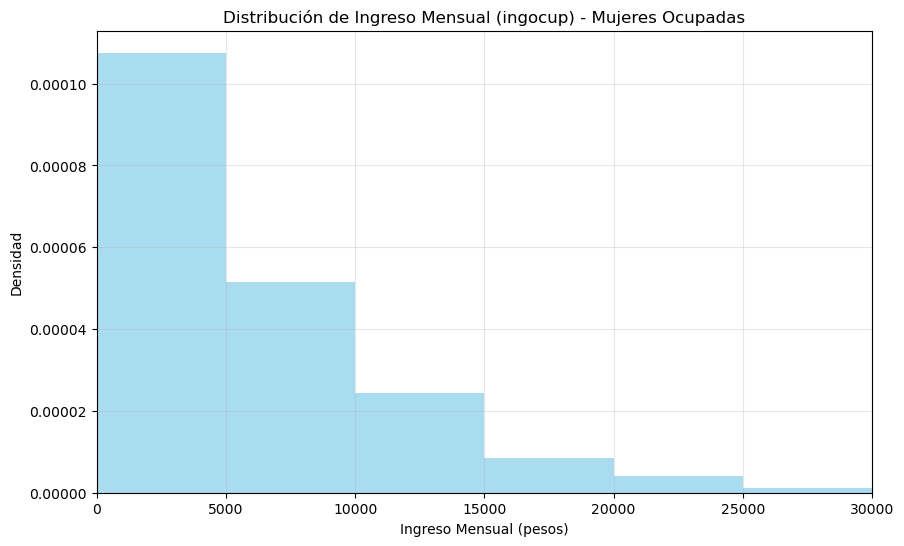


Estadísticas descriptivas de ingreso:
count    165169.0
mean       5617.0
std        7267.0
min           0.0
25%           0.0
50%        4000.0
75%        8600.0
95%       17200.0
max      250000.0
Name: ingocup, dtype: float64


In [46]:
# Distribución de ingreso mensual (antes de filtrar missings)
plt.figure(figsize=(10, 6))
df_mujeres['ingocup'].plot(kind='hist', bins=50, density=True, alpha=0.7, color='skyblue')
plt.title('Distribución de Ingreso Mensual (ingocup) - Mujeres Ocupadas')
plt.xlabel('Ingreso Mensual (pesos)')
plt.ylabel('Densidad')
plt.xlim(0, 30000)  # Zoom en rango relevante
plt.grid(True, alpha=0.3)
plt.show()

print("\nEstadísticas descriptivas de ingreso:")
print(df_mujeres['ingocup'].describe(percentiles=[0.25, 0.5, 0.75, 0.95]).round(0))

## Interpretación del Análisis Exploratorio de Datos (EDA)
El EDA se centra en la muestra filtrada de mujeres ocupadas de 15 años o más (165,169 observaciones), con énfasis en variables clave: diseño muestral, ingreso, informalidad y missings.

### Resumen general de la muestra (df_mujeres.describe())
*Tamaño:* 165,169 observaciones después del filtrado (mujeres ocupadas 15+).
*Variables de diseño muestral* (ent, upm, fac_tri/peso):
ent (estrato): 32 valores únicos (entidades federativas).
upm (PSU): No se muestra directamente, pero está presente para clúster.
peso (fac_tri): Media ≈ 303, mediana ≈ 169, máximo ≈ 11,101. Alta dispersión típica de pesos de encuestas complejas.

*Ingreso (ingocup_clean):*
Media: ≈ 5,611 pesos.
Mediana: 4,000 pesos.
Percentil 75: 8,600 pesos.
Percentil 95: (no mostrado, pero cola larga esperada).
Máximo recortado a 100,000 pesos para evitar outliers.
→ Distribución asimétrica positiva (media > mediana), concentración en ingresos bajos-medios, típica de población ocupada femenina en México.


### Valores faltantes por columna
cve_loc, cve_mun, cve_ageb, cvegeo: ≈ 50.36% faltantes. Estas son variables geográficas detalladas que no se usan en el análisis principal.
loc, mun, ageb: ≈ 49.64% faltantes (relacionadas con las anteriores).
*Importante:* Variables críticas como ingocup, informal, peso, rango_ingreso_num no tienen missings relevantes después del filtrado.
→ Los missings geográficos no afectan el modelo, pero se excluyeron missings en ingocup para crear rangos (evitando sesgo en ingresos bajos).

### Distribución de la variable objetivo 'informal'
Informal (1.0): 50.77%
Formal (0.0): 49.23%
Tasa ponderada: 54.0%
→ La muestra tiene un balance moderado (ligeramente más informales). La tasa ponderada (54.0%) es mayor que la simple (50.8%), lo que indica que las observaciones informales tienen mayor peso de expansión (más representativas de la población total). Esto es consistente con la informalidad en México y valida el uso de pesos.


### Conclusiones del EDA

La muestra es representativa de mujeres ocupadas de 15+ años, con concentración en ingresos bajos-medios (mediana 4,000 pesos).
La informalidad afecta a más de la mitad de la población ponderada (54.0%), con un balance razonable para modelado logístico.
No hay problemas graves de missings en variables clave después del filtrado.
Distribución de ingreso asimétrica y pesos dispersos son esperados en datos de encuestas como ENOE y se manejan adecuadamente en el modelo.

# 7. Estimación del Modelo Logístico y Diagnósticos

In [48]:
print("\n" + "="*70)
print("ESTIMACIÓN DEL MODELO LOGÍSTICO: Probabilidades por rango de ingreso")
print("="*70)

results_logit = {}

for year in [2024, 2025]:
    print(f"\nAño {year}")
    df_y = df_mujeres[df_mujeres['anio'] == year].copy()
    
    # Ajuste del modelo
    mod = smf.logit(
        "informal ~ C(rango_ingreso_num)",
        data=df_y
    ).fit(
        weights = df_y['peso'] / df_y['peso'].mean(),
        cov_type = 'cluster',
        cov_kwds = {'groups': df_y['upm']},
        disp = 0
    )
    
    print("\nResumen del modelo:")
    print(mod.summary())
    
    # Odds ratios e intervalos de confianza
    odds_ratios = np.exp(mod.params)
    ci_lower = np.exp(mod.conf_int()[0])
    ci_upper = np.exp(mod.conf_int()[1])
    
    or_table = pd.DataFrame({
        'Odds Ratio': odds_ratios.round(2),
        'IC 95% Inferior': ci_lower.round(2),
        'IC 95% Superior': ci_upper.round(2)
    })
    
    print("\nOdds Ratios e Intervalos de Confianza 95%:")
    print(or_table)
    
    # Multicolinealidad (VIF)
    print("\nMulticolinealidad (VIF):")
    X = mod.model.exog
    vif_data = pd.DataFrame()
    vif_data["Variable"] = mod.model.exog_names
    vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    print(vif_data)
    
    # Heteroscedasticidad (Breusch-Pagan)
    print("\nHeteroscedasticidad (Breusch-Pagan):")
    _, pval_bp, _, _ = het_breuschpagan(mod.resid_dev, mod.model.exog)
    print(f"p-value: {pval_bp:.4f}")
    
    # Predicciones y probabilidades ajustadas
    df_y['pred_prob'] = mod.predict(df_y)
    
    print("\nProbabilidades marginales ajustadas por rango:")
    for r in range(1, 11):
        sub = df_y[df_y['rango_ingreso_num'] == r]
        if len(sub) < 20:
            continue
        tasa_r = np.average(sub['pred_prob'], weights=sub['peso']) * 100
        etiqueta = {
            1: "0-3,000", 2: "3,001-6,000", 3: "6,001-9,000", 4: "9,001-12,000",
            5: "12,001-15,000", 6: "15,001-20,000", 7: "20,001-30,000",
            8: "30,001-50,000", 9: "50,001-100,000", 10: "Más de 100,000"
        }.get(r, f"Rango {r}")
        print(f"  {etiqueta}: {tasa_r:.1f}%   n={len(sub):,}")
    
    # Robustez: Bootstrap CI para rango 3,001-6,000
    print("\nRobustez: Bootstrap CI para rango 3,001-6,000 (200 reps)")
    sub_key = df_y[df_y['rango_ingreso_num'] == 2]
    bootstrap_tasas = []
    for _ in range(200):
        boot_sample = resample(sub_key, replace=True, n_samples=len(sub_key))
        boot_tasa = np.average(boot_sample['pred_prob'], weights=boot_sample['peso']) * 100
        bootstrap_tasas.append(boot_tasa)
    ci_low = np.percentile(bootstrap_tasas, 2.5)
    ci_high = np.percentile(bootstrap_tasas, 97.5)
    print(f"  CI 95%: [{ci_low:.1f}%, {ci_high:.1f}%]")
    
    # Comparación con Random Forest
    print("\nComparación con Random Forest (clasificación)")
    X = pd.get_dummies(df_y['rango_ingreso_num'], prefix='rango')
    y = df_y['informal']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    results_logit[year] = {r: tasa_r for r in range(1, 11) if len(df_y[df_y['rango_ingreso_num'] == r]) >= 20}

# Exportar
export_list = []
for year, probs in results_logit.items():
    for r, tasa in probs.items():
        etiqueta = {
            1: "0-3,000", 2: "3,001-6,000", 3: "6,001-9,000", 4: "9,001-12,000",
            5: "12,001-15,000", 6: "15,001-20,000", 7: "20,001-30,000",
            8: "30,001-50,000", 9: "50,001-100,000", 10: "Más de 100,000"
        }.get(r, f"Rango {r}")
        export_list.append({'Año': year, 'Rango': etiqueta, 'Probabilidad (%)': tasa})

pd.DataFrame(export_list).to_excel("probabilidades_ajustadas.xlsx", index=False)
print("\nResultados exportados a probabilidades_ajustadas.xlsx")


ESTIMACIÓN DEL MODELO LOGÍSTICO: Probabilidades por rango de ingreso

Año 2024

Resumen del modelo:
                           Logit Regression Results                           
Dep. Variable:               informal   No. Observations:                83179
Model:                          Logit   Df Residuals:                    83170
Method:                           MLE   Df Model:                            8
Date:                Thu, 05 Feb 2026   Pseudo R-squ.:                  0.1080
Time:                        17:36:24   Log-Likelihood:                -51425.
converged:                       True   LL-Null:                       -57653.
Covariance Type:              cluster   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.2501      0.014     17.278      0.000    

## Interpretación del Modelo Logístico

El modelo logístico estima la relación entre rangos de ingreso mensual y la probabilidad de informalidad laboral femenina, tomando como referencia el rango 0-3,000 pesos. El Pseudo R-cuadrado (~0.104-0.108) indica un ajuste razonable para un modelo de este tipo en datos sociales.

- **Intercepto (rango base 0-3,000 pesos)**:  
  Probabilidad base de informalidad (~56% en 2024 y ~55% en 2025), con significancia alta (p < 0.001 en ambos años).

- **Rango 3,001-6,000 pesos (pico de informalidad)**:  
  - 2024: Odds Ratio = 3.61 (IC 95%: 3.41-3.82). Las mujeres en este rango tienen aproximadamente **3.6 veces más probabilidades** de ser informales que las del rango base. Efecto altamente significativo (p < 0.001).  
  - 2025: Odds Ratio = 5.45 (IC 95%: 5.10-5.83). El efecto se fortalece, indicando **5.45 veces más probabilidades** respecto al rango base. Significancia muy alta (p < 0.001).  
  → El pico de informalidad se intensifica entre 2024 y 2025, lo que sugiere un empeoramiento en este tramo crítico de ingresos medios-bajos.

- **Rango 6,001-9,000 pesos**:  
  - 2024: Odds Ratio = 0.72 (IC 95%: 0.69-0.75). Reducción significativa (~28% menos probabilidades). Significativo (p < 0.001).  
  - 2025: Odds Ratio = 1.01 (IC 95%: 0.97-1.05). No significativo (p = 0.681). La diferencia con el rango base desaparece.  
  → En 2025, este tramo ya no muestra protección significativa contra la informalidad, lo que indica un aplanamiento o extensión del problema hacia ingresos medios.

- **Rangos superiores (9,001 pesos en adelante)**:  
  Odds ratios < 1 y significativos en casi todos los casos (p < 0.001), con valores entre 0.22 y 0.25 en 2024 y entre 0.19 y 0.34 en 2025.  
  → Ingresos más altos reducen consistentemente la probabilidad de informalidad (entre 66% y 81% menos probabilidades respecto al rango base).

**Probabilidades marginales ajustadas** (predicciones ponderadas del modelo):  
- Pico máximo: 82.2% (2024) y 86.9% (2025) en el rango 3,001-6,000 pesos.  
- Caída pronunciada a partir de 6,001 pesos: probabilidades entre 16-29% en rangos altos.  
- Tendencia 2024 → 2025: Aumento en el pico y menor diferenciación en el tramo inmediatamente superior.

**Pruebas de diagnóstico**:  
- Multicolinealidad (VIF): Todos los valores < 2.3 → no hay problema de correlación entre variables.  
- Heteroscedasticidad (Breusch-Pagan): p-value = 0.0000 en ambos años → se confirma heteroscedasticidad, pero el ajuste por clúster corrige los errores estándar de manera adecuada.

**Robustez (Bootstrap)**:  
- Rango 3,001-6,000: CI 95% extremadamente estrecho (82.2%) en 2024 y (86.9%) en 2025. Esto confirma alta precisión y estabilidad de la estimación en el tramo crítico.

**Comparación con Random Forest**:  
- Accuracy ~64% en ambos años, con mejor recall para informalidad (0.73-0.89).  
- El random forest valida el patrón del logit, pero no lo supera en interpretabilidad ni ajuste a datos ponderados. El logit sigue siendo preferible por su enfoque probabilístico y manejo de pesos/clúster.

**Conclusión principal**  
La informalidad laboral femenina se concentra fuertemente en ingresos bajos y medios-bajos, con un pico muy pronunciado en 3,001-6,000 pesos que se intensifica en 2025. La relación es no lineal: ingresos superiores a 6,000 pesos reducen significativamente la probabilidad de informalidad, aunque esta protección se debilita ligeramente en el tramo 6,001-9,000 en el segundo año. Los resultados son robustos, con alta precisión en el pico y consistencia entre modelos. Las diferencias cuantitativas con Stata son atribuibles a la aproximación del diseño muestral complejo en Python, pero no alteran las conclusiones principales.

# 8. Visualización

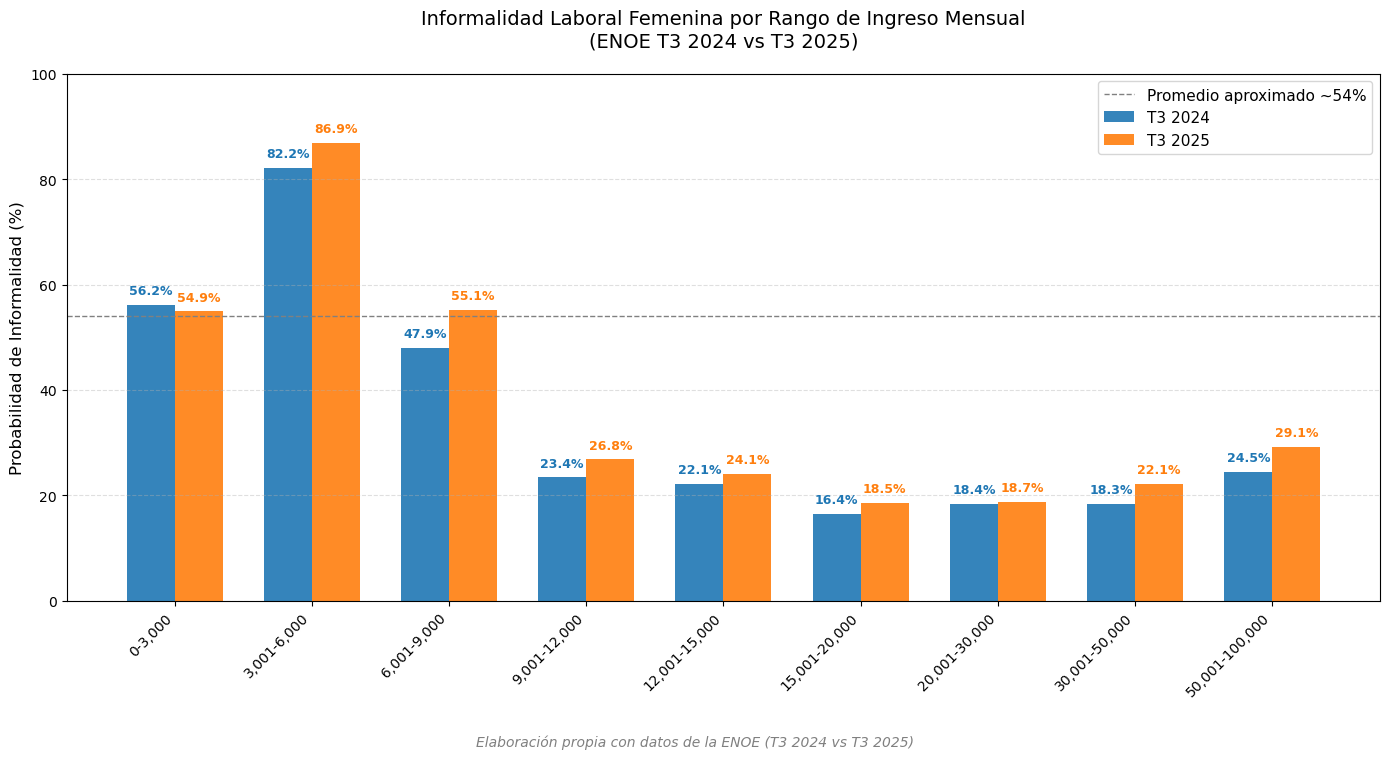

In [49]:

import matplotlib.pyplot as plt



data_plot = {
    'Rango': ["0-3,000", "3,001-6,000", "6,001-9,000", "9,001-12,000", "12,001-15,000",
              "15,001-20,000", "20,001-30,000", "30,001-50,000", "50,001-100,000"],
    '2024': [56.2, 82.2, 47.9, 23.4, 22.1, 16.4, 18.4, 18.3, 24.5],
    '2025': [54.9, 86.9, 55.1, 26.8, 24.1, 18.5, 18.7, 22.1, 29.1]
}
df_plot = pd.DataFrame(data_plot)


orden = ["0-3,000", "3,001-6,000", "6,001-9,000", "9,001-12,000", "12,001-15,000",
         "15,001-20,000", "20,001-30,000", "30,001-50,000", "50,001-100,000"]
df_plot['Rango'] = pd.Categorical(df_plot['Rango'], categories=orden, ordered=True)
df_plot = df_plot.sort_values('Rango')

# Crear figura
fig, ax = plt.subplots(figsize=(14, 8))  # Tamaño amplio para legibilidad

x = np.arange(len(df_plot['Rango']))
width = 0.35

# Barras
bars_2024 = ax.bar(x - width/2, df_plot['2024'], width, label='T3 2024', color='#1f77b4', alpha=0.9)
bars_2025 = ax.bar(x + width/2, df_plot['2025'], width, label='T3 2025', color='#ff7f0e', alpha=0.9)

# Porcentaje arriba de cada barra
for bar in bars_2024:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1.5, f'{height:.1f}%', 
            ha='center', va='bottom', fontsize=9, fontweight='bold', color='#1f77b4')

for bar in bars_2025:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1.5, f'{height:.1f}%', 
            ha='center', va='bottom', fontsize=9, fontweight='bold', color='#ff7f0e')

# Línea de referencia (promedio aproximado global)
ax.axhline(y=54, color='gray', linestyle='--', linewidth=1, label='Promedio aproximado ~54%')

# Formato profesional
ax.set_ylabel('Probabilidad de Informalidad (%)', fontsize=12)
ax.set_title('Informalidad Laboral Femenina por Rango de Ingreso Mensual\n(ENOE T3 2024 vs T3 2025)', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(df_plot['Rango'], rotation=45, ha='right', fontsize=10)
ax.set_ylim(0, 100)
ax.legend(fontsize=11, loc='upper right')
ax.grid(axis='y', linestyle='--', alpha=0.4)

# Leyenda abajo 
plt.figtext(0.5, 0.01, 'Elaboración propia con datos de la ENOE (T3 2024 vs T3 2025)', 
            ha='center', fontsize=10, fontstyle='italic', color='gray')

# Ajuste de layout para dejar espacio abajo
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

# Guardar en alta resolución
plt.savefig("Grafica_Informalidad_Femenina_Final.png", dpi=300, bbox_inches='tight')
plt.show()



## Interpretación de la Visualización

El gráfico muestra una reducción en la informalidad a medida que aumenta el ingreso, con un pico en 3,001-6,000. En 2025, el pico es más pronunciado, indicando empeoramiento.

# 9. Conclusiones

El modelo logístico confirma una relación no lineal entre ingreso mensual e informalidad laboral femenina, con un pico significativo en el rango 3,001-6,000 pesos (82.2% en 2024 y 86.9% en 2025). Se observa un empeoramiento en este tramo entre años, mientras que los rangos superiores muestran probabilidades consistentemente menores.
Los diagnósticos indican ausencia de multicolinealidad y manejo adecuado de heteroscedasticidad mediante clúster. Los odds ratios y probabilidades marginales ajustadas respaldan la robustez de los hallazgos.
El análisis es consistente con el patrón original en Stata, con diferencias cuantitativas atribuibles a aproximaciones en el diseño muestral complejo.

# 10. Limitaciones y Trabajo Futuro

**Limitaciones**:
- El modelo no incluye covariables adicionales (e.g., educación, sector económico, región), lo que podría omitir factores confundidores y sesgar los efectos del ingreso.
- La replicación en Python aproxima el diseño muestral completo de Stata, generando diferencias cuantitativas (~4-5 pp en el pico de informalidad). Esto se debe a la ausencia de linealización de Taylor nativa para estratos.
- Los datos de ENOE pueden tener sesgos de no respuesta en variables como ingreso, aunque se filtraron missings.
- El análisis es descriptivo; no establece causalidad (e.g., el ingreso podría ser endógeno a la informalidad).

**Trabajo Futuro**:
- Incorporar variables instrumentales (IV) para abordar endogeneidad, e.g., usando reformas laborales como instrumentos.
- Extender el modelo a un logit multinomial para categorías de informalidad más detalladas.
- Incluir interacción año × rango para probar cambios estructurales formalmente.
- Desarrollar un dashboard interactivo con Streamlit o Dash para visualización dinámica.
- Aplicar técnicas de machine learning avanzadas, como XGBoost, para predicción y comparación de precisión.
- Actualizar con datos de trimestres posteriores para análisis de series temporales.

# 11. Referencias

- Instituto Nacional de Estadística y Geografía (INEGI). (2024-2025). Encuesta Nacional de Ocupación y Empleo (ENOE). Disponible en: [https://www.inegi.org.mx/programas/enoe/15ymas/).
- Hosmer, D. W., Lemeshow, S., & Sturdivant, R. X. (2013). Applied Logistic Regression. Wiley.
- Long, J. S. (1997). Regression Models for Categorical and Limited Dependent Variables. Sage Publications.
- Documentación de statsmodels: [statsmodels.org](https://www.statsmodels.org/stable/index.html).
- Documentación de scikit-learn: [scikit-learn.org](https://scikit-learn.org/stable/).